## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from random import sample
import sklearn.model_selection as skl

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

analysis_df = all_xray_df.copy()

Scans found: 112120 , Total Headers 112120


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*analysis_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        analysis_df[c_label] = analysis_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
analysis_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
70432,00017364_001.png,No Finding,1,17364,61,M,PA,2826,2981,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
51330,00012973_004.png,Edema|Effusion|Mass,4,12973,58,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
78114,00019176_024.png,Atelectasis|Infiltration,24,19176,67,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
analysis_df['pneumonia_class'] = analysis_df['Pneumonia'].map(lambda i: 'With Pneumonia' if i==1 else 'Without Pneumonia')

## Create your training and testing data:

In [5]:
def create_splits(analysis_df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_df, valid_df = skl.train_test_split(analysis_df, 
                                   test_size = 0.2, 
                                   stratify = analysis_df['Pneumonia'])
    train_df['Pneumonia'].sum()/len(train_df)
    valid_df['Pneumonia'].sum()/len(valid_df)
    pnuemonia_present = train_df[train_df.Pneumonia==1].index.tolist()
    pnuemonia_absent = train_df[train_df.Pneumonia==0].index.tolist()
#     print("Yes",len(pnuemonia_present))
#     print("No",len(pnuemonia_absent))
    np_sample = sample(pnuemonia_absent,len(pnuemonia_present))
    train_df = train_df.loc[pnuemonia_present + np_sample]
    pnuemonia_present = valid_df[valid_df.Pneumonia==1].index.tolist()
    pnuemonia_absent = valid_df[valid_df.Pneumonia==0].index.tolist()
#     print("Yes",len(pnuemonia_present))
#     print("No",len(pnuemonia_absent))
    np_sample = sample(pnuemonia_absent,4*len(pnuemonia_present))
    valid_df = valid_df.loc[pnuemonia_present + np_sample]
    
    return train_df, valid_df

In [6]:
train_df, valid_df = create_splits(analysis_df)

In [7]:
valid_df['Pneumonia'].value_counts()

0.0    1144
1.0     286
Name: Pneumonia, dtype: int64

In [8]:
train_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
93110,00023271_002.png,Edema|Pneumonia,2,23271,40,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,With Pneumonia
74619,00018319_001.png,Pneumonia,1,18319,8,M,AP,2344,3056,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,With Pneumonia
104777,00028076_000.png,Pneumonia,0,28076,7,F,PA,1762,1578,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,With Pneumonia
63765,00015732_047.png,Edema|Infiltration|Pneumonia,47,15732,48,F,AP,2500,2048,0.168000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,With Pneumonia
8613,00002275_019.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,19,2275,65,M,PA,2992,2991,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,With Pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16534,00004424_000.png,No Finding,0,4424,28,F,PA,2048,2500,0.171000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Without Pneumonia
105751,00028458_001.png,Atelectasis,1,28458,76,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Without Pneumonia
69327,00017110_016.png,Emphysema,16,17110,59,F,PA,2710,2605,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Without Pneumonia
19928,00005321_000.png,No Finding,0,5321,49,M,PA,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Without Pneumonia


In [9]:
IMG_SIZE = (224, 224)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [10]:
def my_image_augmentation(dataset_type):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    if dataset_type == 'train_data':
        idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.15,
                              zoom_range=0.11)
    if dataset_type == 'valid_data':
        idg = ImageDataGenerator(rescale=1. /255.0)  
    return idg


def make_train_gen(train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    dataset_type = 'train_data'
    my_train_idg = my_image_augmentation(dataset_type)
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path' ,
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE , 
                                         batch_size = 32
                                         )
     # Todo

    return train_gen


def make_val_gen(valid_df):
    
    dataset_type = 'valid_data'
    my_val_idg = my_image_augmentation(dataset_type)
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = valid_df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE , 
                                             batch_size = 64) 
    
    # Todo
    return val_gen

In [11]:
gen_train = make_train_gen(train_df)
gen_valid = make_val_gen(valid_df)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [12]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = gen_valid.next()


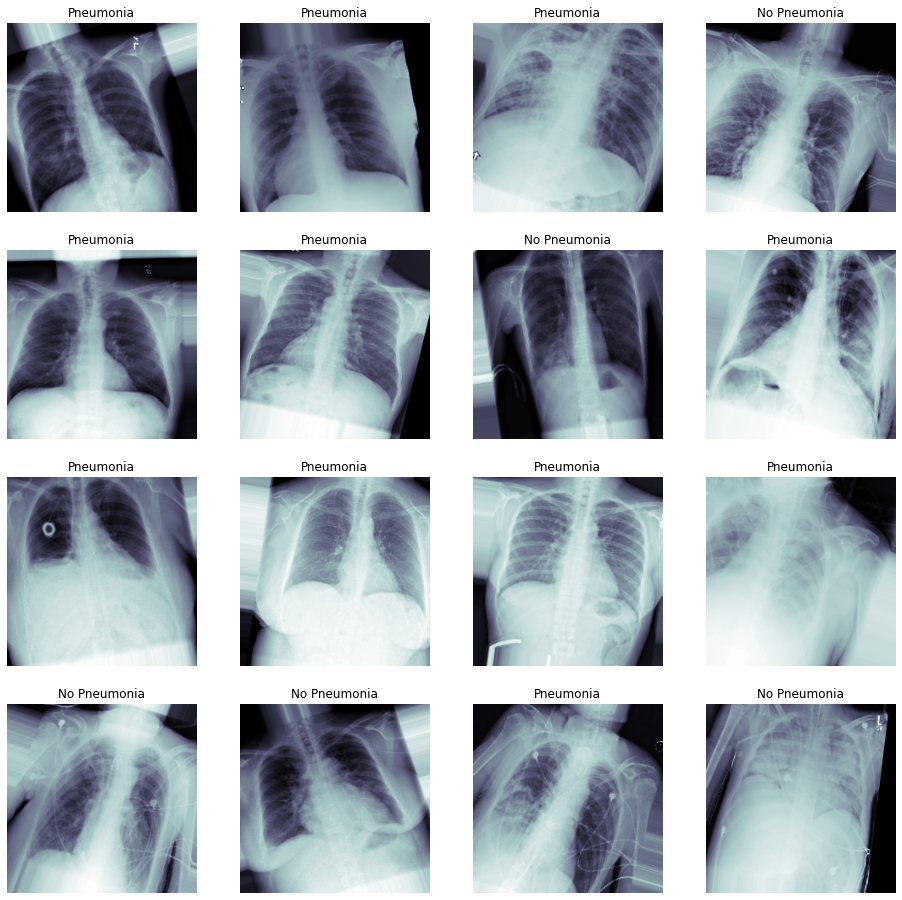

In [13]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(gen_train)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [14]:
def load_pretrained_model():
    
    vgg_model = VGG16(include_top=False, weights='imagenet')
#     transfer_layer = model.get_layer("block5_pool")
#     vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    return vgg_model


In [15]:
vgg_model = load_pretrained_model()


58892288/58889256 [==============================] - 1s 0us/step


In [16]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [17]:
## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
## Here, we'll freeze all but the last convolutional layer

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [18]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [19]:
#Repeating above steps with some additional convolutional layers
def build_my_model_v2():
    
    my_model_v2 = Sequential()
    
    my_model_v2.add(vgg_model)
    
    my_model_v2.add(GlobalAveragePooling2D())
    
    my_model_v2.add(Dense(256, activation='relu'))
    
    my_model_v2.add(BatchNormalization())
    
    my_model_v2.add(Dropout(0.5))
    
    my_model_v2.add(Dense(64, activation='relu'))
    
    my_model_v2.add(BatchNormalization())
    
    my_model_v2.add(Dropout(0.5))
    
    my_model_v2.add(Dense(32, activation='relu'))
    
    my_model_v2.add(BatchNormalization())
    
    my_model_v2.add(Dropout(0.5))
    
    my_model_v2.add(Dense(1, activation='sigmoid'))
    
    return my_model_v2

In [20]:
weight_path="{}_my_model.h5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = False)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=0.0001, verbose=1)

callbacks_list = [checkpoint, early,reduce_lr]

In [21]:
my_model_v2 = build_my_model_v2()

In [22]:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

my_model_v2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [23]:
my_model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)               

In [24]:
## train your model
history = my_model_v2.fit_generator(gen_train,
                          validation_data = gen_valid,
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
72/72 [==============================] - 86s 1s/step - loss: 0.9680 - binary_accuracy: 0.5258 - val_loss: 0.6996 - val_binary_accuracy: 0.3958

Epoch 00001: val_loss improved from inf to 0.69958, saving model to xray_class_my_model.h5
Epoch 2/10
72/72 [==============================] - 64s 895ms/step - loss: 0.9168 - binary_accuracy: 0.5384 - val_loss: 0.6685 - val_binary_accuracy: 0.6196

Epoch 00002: val_loss improved from 0.69958 to 0.66850, saving model to xray_class_my_model.h5
Epoch 3/10
72/72 [==============================] - 67s 929ms/step - loss: 0.9029 - binary_accuracy: 0.5362 - val_loss: 0.7254 - val_binary_accuracy: 0.4937

Epoch 00003: val_loss did not improve from 0.66850
Epoch 4/10
72/72 [==============================] - 67s 929ms/step - loss: 0.8940 - binary_accuracy: 0.5393 - val_loss: 0.6820 - val_binary_accuracy: 0.5552

Epoch 00004: val_loss did not improve from 0.66850
Epoch 5/10
72/72 [==============================] - 67s 935ms/step - loss: 0.8955 -

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [26]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model_v2.load_weights(weight_path)
pred_Y = my_model_v2.predict(valX, batch_size = 32, verbose = True)

64/64 [==============================] - 1s 13ms/step


In [27]:
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    c_ax.set_title('Precision Recall Curve')

# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

def plot_roc_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    c_ax.set_title('ROC Curve')

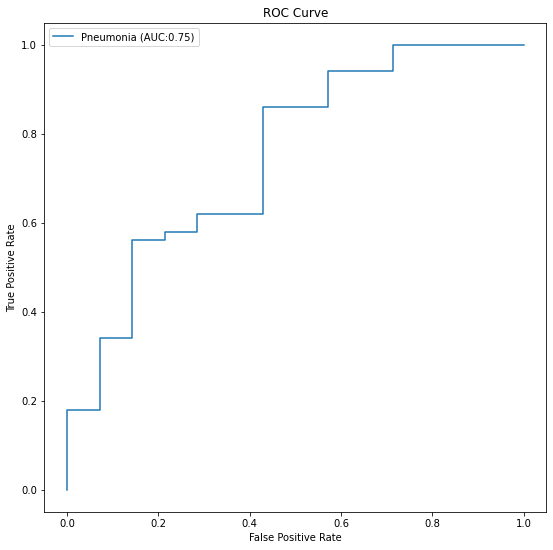

In [28]:
plot_roc_curve(valY,pred_Y)

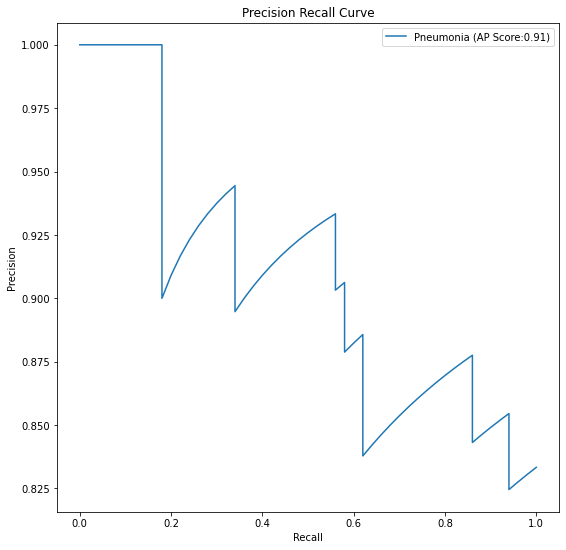

In [29]:
plot_precision_recall_curve(valY,pred_Y)

In [30]:
precision, recall, thresholds = precision_recall_curve(valY,pred_Y)


In [31]:
f1_score = [calc_f1(precision[thres], recall[thres]) for thres in range(len(thresholds))]

In [32]:
print(f1_score)

[0.9090909090909091, 0.8990825688073395, 0.888888888888889, 0.8785046728971964, 0.8867924528301886, 0.8952380952380952, 0.8846153846153846, 0.8737864077669903, 0.8627450980392156, 0.8514851485148515, 0.8599999999999999, 0.8686868686868686, 0.8571428571428572, 0.8453608247422681, 0.8333333333333333, 0.8210526315789474, 0.8085106382978724, 0.7956989247311828, 0.782608695652174, 0.7692307692307692, 0.7555555555555556, 0.7415730337078651, 0.7272727272727272, 0.7126436781609196, 0.7209302325581396, 0.7294117647058823, 0.7142857142857143, 0.6987951807228915, 0.7073170731707317, 0.691358024691358, 0.7000000000000001, 0.6835443037974683, 0.6666666666666666, 0.6493506493506493, 0.631578947368421, 0.6133333333333333, 0.5945945945945945, 0.5753424657534246, 0.5555555555555556, 0.5352112676056339, 0.5142857142857143, 0.4927536231884058, 0.5, 0.4776119402985075, 0.45454545454545453, 0.4307692307692308, 0.40625, 0.38095238095238093, 0.3548387096774193, 0.32786885245901637, 0.3, 0.3050847457627119, 0

In [33]:
val_threshold = thresholds[np.argmax(f1_score)]
print("Threshold_value:",val_threshold)
print("Recall for the above threshold value is: " + str(recall[np.argmax(f1_score)]))
print("Precision for the above threshold value is: " + str(precision[np.argmax(f1_score)]))
print("F1 score for the above threshold value is: "+ str(f1_score[np.argmax(f1_score)]))

Threshold_value: 0.4552223
Recall for the above threshold value is: 1.0
Precision for the above threshold value is: 0.8333333333333334
F1 score for the above threshold value is: 0.9090909090909091


In [34]:
# # Look at the threshold where precision is 0.6
# precision_value = 0.6
# idx = (np.abs(precision - precision_value)).argmin() 
# print('Precision is: '+ str(precision[idx]))
# print('Recall is: '+ str(recall[idx]))
# print('Threshold is: '+ str(thresholds[idx]))
# print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

In [35]:
# # Look at the threshold where recall is 0.6
# recall_value = 0.6

# idx = (np.abs(recall - recall_value)).argmin() 
# print('Precision is: '+ str(precision[idx]))
# print('Recall is: '+ str(recall[idx]))
# print('Threshold is: '+ str(thresholds[idx]))
# print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Text(0.5, 1.0, 'F1 Score Vs Thresholds')

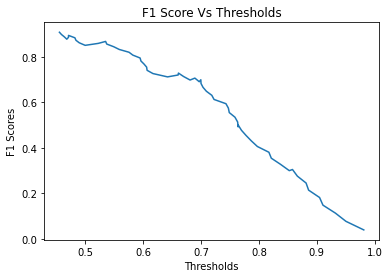

In [36]:
plt.figure()
plt.plot(thresholds, f1_score)
plt.xlabel('Thresholds')
plt.ylabel('F1 Scores')
plt.title('F1 Score Vs Thresholds')


In [37]:
probs = pd.Series(pred_Y[:, 0])

t1 = (probs > 0.5)
t2 = (probs > 0.8)

In [38]:
t1 = t1.replace(True,1).replace(False,0)
t2 = t2.replace(True,1).replace(False,0)

In [39]:
compare_t1 = (t1 == valY[:])
compare_t2 = (t2 == valY[:])

In [40]:
print(len(valY[:]))

64


In [41]:
print('Accuracy at threshold 1: ' + str(len(compare_t1[compare_t1])/len(valY[:])))
print('Accuracy at threshold 2: ' + str(len(compare_t2[compare_t2])/len(valY[:])))

Accuracy at threshold 1: 0.59375
Accuracy at threshold 2: 0.390625


In [42]:
def plot_history(history):
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))
    ax = ax.flatten()
    plt.style.use("ggplot")
    N = len(history.history["loss"])
    
    ax[0].plot(np.arange(N), history.history["loss"], label = 'train_loss')
    ax[0].plot(np.arange(N), history.history["val_loss"], label = 'val_loss')
    ax[0].legend()
    ax[0].set_title('Loss Graph')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')

    
    ax[1].plot(np.arange(N), history.history["binary_accuracy"], label = 'train_binary_accuracy')
    ax[1].plot(np.arange(N), history.history["val_binary_accuracy"], label = 'val_binary_accuracy')
    ax[1].set_title('Accuracy Graph')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')

    
    return

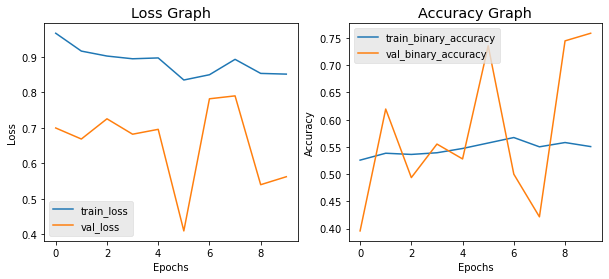

In [43]:
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

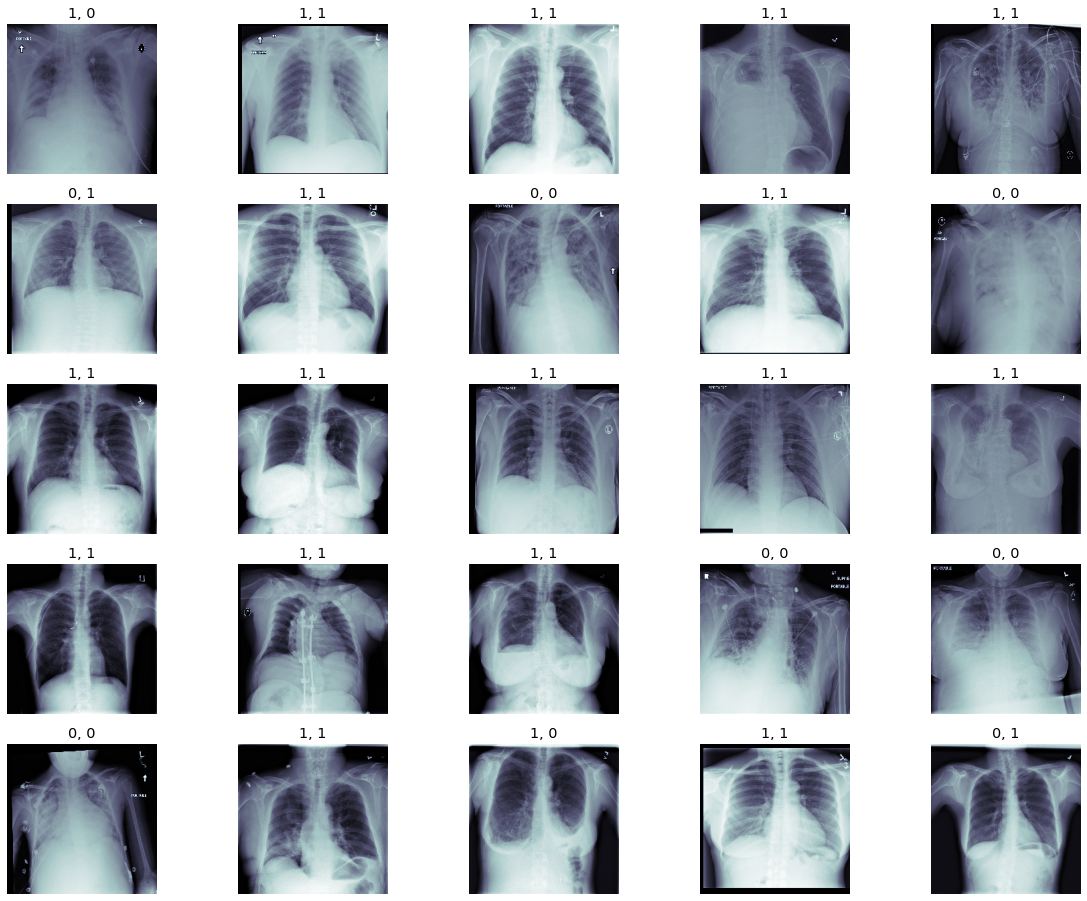

In [44]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(5, 5, figsize = (20, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.47:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.57: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [45]:
## Just save model architecture to a .json:

model_json = my_model_v2.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)